In [47]:
import pandas as pd
import scanpy as sc
from math import acos, sqrt, pi, sin, cos
from scipy.io import mmread
from scipy import sparse
from scipy.optimize import minimize_scalar
import numpy as np
from scipy.optimize import fsolve, root, basinhopping
import matplotlib.pyplot as plt
import h5py
import csv
import os
import loompy
import anndata
from pandas import HDFStore
from sklearn.manifold import TSNE
import collections
import scipy.sparse as sp_sparse
import tables
import plotly.express as px

In [48]:
genes = pd.read_csv("../Data/Genes.csv")
barcode_positions = pd.read_csv("../Data/SpotPositions.csv")
ScatterPies = pd.read_csv("../Data/SpotClusterMembership.csv")
GeneExpression = pd.read_csv("../Data/ClusterGeneExpression.csv")

In [49]:
merged_df = pd.merge(barcode_positions, ScatterPies, on="barcode")
merged_df

,barcode,x,y,radius,X1,X2,X3,X4,X5,X6,X7,X8,X9
0,AAACAAGTATCTCCCA-1,12709.0,10806.0,71.192911,0.176596,0.130452,0.000000,0.277719,0.000000,0.334386,0.000000,0.000000,0.080847
1,AAACACCAATAACTGC-1,3616.0,12513.0,71.192911,0.000000,0.000000,0.000000,0.000000,0.662506,0.000000,0.193410,0.144084,0.000000
2,AAACAGAGCGACTCCT-1,11839.0,3944.0,71.192911,0.000000,0.000000,0.330006,0.000000,0.000000,0.250267,0.000000,0.163155,0.256573
3,AAACAGGGTCTATATT-1,2961.0,10225.0,71.192911,0.000000,0.087536,0.000000,0.000000,0.463777,0.000000,0.237417,0.131194,0.080076
4,AAACATTTCCCGGATT-1,12159.0,12902.0,71.192911,0.197194,0.216818,0.000000,0.126936,0.099019,0.067587,0.292446,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3494,TTGTTGTGTGTCAAGA-1,9974.0,7183.0,71.192911,0.077686,0.000000,0.109485,0.372448,0.095749,0.344632,0.000000,0.000000,0.000000
3495,TTGTTTCACATCCAGG-1,6136.0,12325.0,71.192911,0.055007,0.083465,0.134945,0.000000,0.208435,0.121374,0.000000,0.124215,0.272560
3496,TTGTTTCATTAGTCTA-1,4821.0,12705.0,71.192911,0.000000,0.067899,0.000000,0.000000,0.545618,0.000000,0.161659,0.148889,0.075935
3497,TTGTTTCCATACAACT-1,4495.0,9846.0,71.192911,0.000000,0.000000,0.221199,0.000000,0.171150,0.191596,0.000000,0.175395,0.240660


In [50]:
columns = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9']
cumulativeAngledf = merged_df.copy()
def conditional_cumsum(row):
    cumsum = 0
    for col in columns:
        if row[col] != 0:
            cumsum += row[col]
            row[col] = cumsum
    return row
cumulativeAngledf[columns] = merged_df[columns].apply(conditional_cumsum, axis=1)
cumulativeAngledf

,barcode,x,y,radius,X1,X2,X3,X4,X5,X6,X7,X8,X9
0,AAACAAGTATCTCCCA-1,12709.0,10806.0,71.192911,0.176596,0.307048,0.000000,0.584767,0.000000,0.919153,0.000000,0.000000,1.0
1,AAACACCAATAACTGC-1,3616.0,12513.0,71.192911,0.000000,0.000000,0.000000,0.000000,0.662506,0.000000,0.855916,1.000000,0.0
2,AAACAGAGCGACTCCT-1,11839.0,3944.0,71.192911,0.000000,0.000000,0.330006,0.000000,0.000000,0.580273,0.000000,0.743427,1.0
3,AAACAGGGTCTATATT-1,2961.0,10225.0,71.192911,0.000000,0.087536,0.000000,0.000000,0.551313,0.000000,0.788730,0.919924,1.0
4,AAACATTTCCCGGATT-1,12159.0,12902.0,71.192911,0.197194,0.414012,0.000000,0.540948,0.639966,0.707554,1.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3494,TTGTTGTGTGTCAAGA-1,9974.0,7183.0,71.192911,0.077686,0.000000,0.187171,0.559619,0.655368,1.000000,0.000000,0.000000,0.0
3495,TTGTTTCACATCCAGG-1,6136.0,12325.0,71.192911,0.055007,0.138472,0.273416,0.000000,0.481851,0.603225,0.000000,0.727440,1.0
3496,TTGTTTCATTAGTCTA-1,4821.0,12705.0,71.192911,0.000000,0.067899,0.000000,0.000000,0.613517,0.000000,0.775176,0.924065,1.0
3497,TTGTTTCCATACAACT-1,4495.0,9846.0,71.192911,0.000000,0.000000,0.221199,0.000000,0.392350,0.583945,0.000000,0.759340,1.0


In [168]:
hirescalef = 0.046594715
spotDiameter = 142.38582253945773
# Default circle radius
radius = spotDiameter * hirescalef / 2
d = np.sqrt(2) * radius
print(radius, d, np.sqrt(2) * radius + radius)

3.317213410633305 4.691248194603531 8.008461605236835


In [172]:
# varify the sepcial value
r, d = np.sqrt(2) * radius, np.sqrt(2) * radius
angle1 = np.degrees(np.arccos((r**2 + d**2 - radius**2) / (2 * r * d)))
angle2 = np.degrees(np.arccos((radius**2 + d**2 - r**2) / (2 * radius * d)))
result = angle1 * r**2 + angle2 * radius**2 - d * r * np.sin(angle1)
special_value = result / (np.pi * radius**2)
angle1_deg = np.degrees(angle1)
angle2_deg = np.degrees(angle2)
print(angle1_deg, angle2_deg)
print(r, d, radius * 2 + r)
print(special_value, angle1, angle2)

2372.5965780928423 3970.3218671309883
4.691248194603531 4.691248194603531 11.325675015870141
48.76248801016935 41.40962210927086 69.29518894536457


In [161]:
def equation(r, d, a, radius, special_value):
    angle1 = np.arccos((r**2 + d**2 - radius**2) / (2 * r * d))
    angle2 = np.arccos((radius**2 + d**2 - r**2) / (2 * radius * d))
    if (a <= special_value) :
        result = angle1 * r**2 + angle2 * radius**2 - d * r * np.sin(angle1)
    else:
        result = angle1 * r**2 + angle2 * radius**2 - r**2 * np.sin(angle1) * np.cos(angle1) - radius**2 * np.sin(angle2) * np.cos(angle2)
    return result - (a * np.pi * radius**2)

/var/folders/pm/_db3z8953vb1gtk99jkk_sb80000gn/T/ipykernel_97682/1532942115.py:2: RuntimeWarning: invalid value encountered in arccos
  angle1 = np.arccos((r**2 + d**2 - radius**2) / (2 * r * d))
/var/folders/pm/_db3z8953vb1gtk99jkk_sb80000gn/T/ipykernel_97682/1532942115.py:3: RuntimeWarning: invalid value encountered in arccos
  angle2 = np.arccos((radius**2 + d**2 - r**2) / (2 * radius * d))


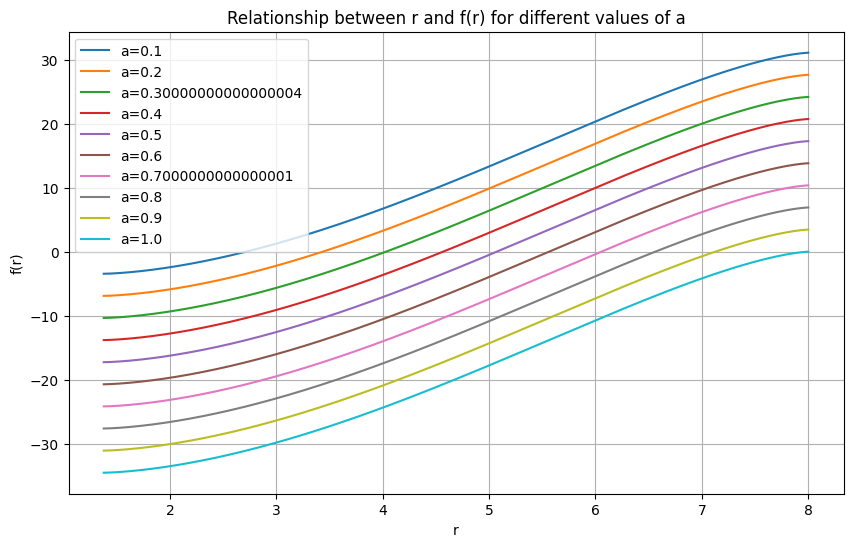

In [162]:
r_values = np.linspace(1, 10, 1000)

# Different values of 'a' to plot
# a_values = [0.1, 0.2, 0.5, 0.7, 0.9, 1]
a_values = np.linspace(0.1, 1, 10)

plt.figure(figsize=(10, 6))
for a in a_values:
    results = [equation(r, d, a, radius, special_value) for r in r_values]
    plt.plot(r_values, results, label=f'a={a}')

plt.xlabel('r')
plt.ylabel('f(r)')
plt.title('Relationship between r and f(r) for different values of a')
plt.legend()
plt.grid(True)
plt.show()


In [174]:
a = 0.5281

def initial_guess(a, d, special_value):
    if a <= special_value:
        return d + 0.01
    elif a > 0.95:
        return 8
    else:    
        return a * 10 - 1.5

guess = initial_guess(a, d, special_value)
r_solution = fsolve(equation, guess, args=(d, a, radius, special_value))
angle1 = np.degrees(np.arccos((r_solution**2 + d**2 - radius**2) / (2 * r_solution * d)))
print("radius:", radius)
print("Initial guess:", guess)

print("Solution for r:", r_solution[0])
print("Angle1:", angle1)


radius: 3.317213410633305
Initial guess: 4.701248194603531
Solution for r: 5.210783941865971
Angle1: [38.69849031]


In [139]:
def initial_guess(a, d, special_value):
    if a <= special_value:
        return d + 0.01
    elif a > 0.95:
        return 8
    else:    
        return a * 10 - 1.5

def calculate_r(df, originaldf):
    result_df = originaldf.copy()
    for index, row in df.iterrows():
        for i in range(1, 10):
            a_value =  row[f"X{i}"]
            if a_value == 0:
                cal_radius = 0
                angle = 0
            else:
                try:
                    guess = initial_guess(a_value, d, special_value)
                    cal_radius = fsolve(equation, guess, args=(d, a_value, radius, special_value))[0]
                    angle = np.degrees(np.arccos((cal_radius**2 + d**2 - radius**2) / (2 * cal_radius * d)))
                except ValueError as e:
                    print(f"Index {index}, X{i}, a={a_value}: {e}")
                    cal_radius = np.nan
                    angle = np.nan
            result_df.loc[index, f"X{i}_radius"] = cal_radius
            result_df.loc[index, f"X{i}_angle"] = angle
    
    return result_df

result_df = calculate_r(cumulativeAngledf, merged_df)

for index, row in result_df.iterrows():
    print(f"Index {index}:")
    for i in range(1, 10):
        print(f"X{i}: {row[f'X{i}']}, X{i}_radius: {row[f'X{i}_radius']}, X{i}_angle: {row[f'X{i}_angle']}")

/var/folders/pm/_db3z8953vb1gtk99jkk_sb80000gn/T/ipykernel_97682/1532942115.py:2: RuntimeWarning: invalid value encountered in arccos
  angle1 = np.arccos((r**2 + d**2 - radius**2) / (2 * r * d))
/var/folders/pm/_db3z8953vb1gtk99jkk_sb80000gn/T/ipykernel_97682/1532942115.py:3: RuntimeWarning: invalid value encountered in arccos
  angle2 = np.arccos((radius**2 + d**2 - r**2) / (2 * radius * d))
/Users/siyuanzhao/anaconda3/envs/VDS/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/var/folders/pm/_db3z8953vb1gtk99jkk_sb80000gn/T/ipykernel_97682/1532942115.py:2: RuntimeWarning: invalid value encountered in arccos
  angle1 = np.arccos((r**2 + d**2 - radius**2) / (2 * r * d))
/var/folders/pm/_db3z8953vb1gtk99jkk_sb80000gn/T/ipykernel_97682/1532942115.py:3: RuntimeWarning: invalid value encountered in arccos
  angle2 = n

Index 0:
X1: 0.176595707865445, X1_radius: 3.2832402230444386, X1_angle: 44.99696400770176
X2: 0.130452435507047, X2_radius: 4.071471753614137, X2_angle: 43.78019959843802
X3: 0.0, X3_radius: 0.0, X3_angle: 0.0
X4: 0.277718661901317, X4_radius: 5.487903680759175, X4_angle: 37.001737357913036
X5: 0.0, X5_radius: 0.0, X5_angle: 0.0
X6: 0.334386380644337, X6_radius: 7.2485424302441235, X6_angle: 20.87503618016204
X7: 0.0, X7_radius: 0.0, X7_angle: 0.0
X8: 0.0, X8_radius: 0.0, X8_angle: 0.0
X9: 0.0808468140818537, X9_radius: 8.008461603705724, X9_angle: 0.0009421259690103695
Index 1:
X1: 0.0, X1_radius: 0.0, X1_angle: 0.0
X2: 0.0, X2_radius: 0.0, X2_angle: 0.0
X3: 0.0, X3_radius: 0.0, X3_angle: 0.0
X4: 0.0, X4_radius: 0.0, X4_angle: 0.0
X5: 0.662506365258785, X5_radius: 5.867646406141648, X5_angle: 34.385141500732644
X6: 0.0, X6_radius: 0.0, X6_angle: 0.0
X7: 0.193409565157925, X7_radius: 6.866804562365619, X7_angle: 25.488939097581394
X8: 0.14408406958329, X8_radius: 8.008461602012341, X8

In [140]:
result_df.to_csv("../Frontend/src/data/kosaraChart.csv", index=False)